## CRIER: Custom Reverse Image Extractions Ranked

<table class="tfo-notebook-buttons" align="left">

  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ashaltu/crier/blob/master/crier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>

  <td>
    <a target="_blank" href="https://github.com/ashaltu/crier/blob/master/crier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>

</table>

### Install modules

In [ ]:
!apt install subversion
!pip install scann

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1
Suggested packages:
  db5.3-util libapache2-mod-svn subversion-tools
The following NEW packages will be installed:
  libapr1 libaprutil1 libserf-1-1 libsvn1 subversion
0 upgraded, 5 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,237 kB of archives.
After this operation, 9,910 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libapr1 amd64 1.6.3-2 [90.9 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libaprutil1 amd64 1.6.1-2 [84.4 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libserf-1-1 amd64 1.3.9-6 [44.4 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libsvn1 amd64 1.9.7-4ubuntu1 [1,183 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/universe amd64 subversion amd64 1.9.7-4ubuntu1 

### Imports

In [ ]:
import os
import glob
import math
import scann
import numpy as np

import tensorflow as tf
import tensorflow_hub as tfhub

from google.colab import files

### Download tiny example image corpus

You can also upload your own image corpus, just make sure to keep it in a folder and also to change `image_corpus_dir` to the correct directory.

In [ ]:
!svn export https://github.com/ashaltu/crier/trunk/example_image_corpus

image_corpus_dir = "/content/example_image_corpus"

A    example_image_corpus
A    example_image_corpus/catt.jpg
A    example_image_corpus/dog_sunflower.jpg
A    example_image_corpus/fcat.jpg
A    example_image_corpus/house.jpg
A    example_image_corpus/house2.jpg
A    example_image_corpus/sunflower.jpg
A    example_image_corpus/sunflower2.jpg
A    example_image_corpus/tree.jpg
Exported revision 6.


### Util functions

In [ ]:
# Build dict mapping image ids to their paths.
def load_image_id_paths_map(images_dir):
  dir_prefix = os.path.join(os.getcwd(), images_dir)
  image_paths = []
  for ext in ['*.png', '*.jpg', '*.jpeg']:
    image_paths.extend(glob.glob(os.path.join(dir_prefix, ext)))
  return {idx: path for idx, path in enumerate(image_paths)}

# Build dict mapping image ids to PIL image instances.
def load_image_id_pil_map(image_id_paths_map, image_size):
  map = dict()
  for idx, path in image_id_paths_map.items():
    map.update({idx: tf.keras.preprocessing.image.load_img(
                        path=path,
                        target_size=image_size,
                        interpolation='bilinear'
                     )
               })
    
  return map

# Normalize an image array to the following range: [0, 1].
def normalize_img_arr(arr):
  return tf.keras.utils.normalize(arr, axis=-1, order=2)

# Build dict mapping image ids to image arrays.
def load_image_id_arr_map(image_id_pil_map):
  map = dict()
  for idx, pil_image in image_id_pil_map.items():
    img_arr = tf.keras.preprocessing.image.img_to_array(pil_image)
    norm_img_arr = normalize_img_arr(img_arr)
    map.update({idx: norm_img_arr})
    
  return map

# Build dict mapping image ids to embeddings.
def load_image_id_embedding_map(model, image_id_arr_map):
  map = dict()
  batched_img_arrs = np.array(list(image_id_arr_map.values()))
  predictions = model.predict(batched_img_arrs)
  for idx, embedding in enumerate(predictions):
    map.update({idx: embedding})

  return map

# Build a ScaNN index for later ANN lookups.
def load_search_engine(corpus_image_embeddings, num_results):
  dataset = np.array(list(corpus_image_embeddings))
  num_leaves = int(math.sqrt(len(corpus_image_embeddings)))

  search_engine = scann.scann_ops_pybind.builder(dataset, num_results, "squared_l2").score_brute_force().build()
  return search_engine

def image_path_to_arr(image_path, image_size):
  pil_image = tf.keras.preprocessing.image.load_img(
                    path=image_path,
                    target_size=image_size,
                    interpolation='bilinear'
                  )
  img_arr = tf.keras.preprocessing.image.img_to_array(pil_image)
  norm_img_arr = normalize_img_arr(img_arr)

  return norm_img_arr

In [ ]:
class CRIER(object):
    def __init__(self, model_handle, image_size, num_results=10, corpus_dir=None):
      self.num_results = num_results
      self.image_size = image_size

      self.encoder = tf.keras.Sequential(
          [
            tf.keras.layers.InputLayer(input_shape=self.image_size + (3,)),
            tfhub.KerasLayer(model_handle, trainable=False),  # Can be True, see below.
          ])
      self.encoder.build((None,)+self.image_size+(3,))        # Batch input shape.
      self.encoder.summary()  

      if corpus_dir:
        self.create_database(corpus_dir)
      

    # Create image database
    def create_database(self, corpus_dir):
      self.corpus_image_id_paths_map = load_image_id_paths_map(corpus_dir)
      self.corpus_image_id_pil_map = load_image_id_pil_map(self.corpus_image_id_paths_map, self.image_size)
      self.corpus_image_id_arr_map = load_image_id_arr_map(self.corpus_image_id_pil_map)
      self.corpus_image_id_embedding_map = load_image_id_embedding_map(self.encoder, self.corpus_image_id_arr_map)
      self.search_engine = load_search_engine(self.corpus_image_id_embedding_map.values(), self.num_results)

    # Update image database
    def update_database(self, corpus_dir):
      self.create_database(corpus_dir)

    # Search image database
    def search_database(self, image_path):
      img_arr = image_path_to_arr(image_path, self.image_size)
      image_embedding = self.encoder.predict(np.array([img_arr]))

      neighbors, distances = self.search_engine.search_batched(image_embedding) # searches sunflower
      images = []
      for idx, neighbor in enumerate(neighbors[0]):
        images.append(self.corpus_image_id_pil_map[neighbor])

        print(f"Image {neighbor} distance: {distances[0][idx]}")
        display(self.corpus_image_id_pil_map[neighbor])
      
      return neighbors, images, distances
    
    def search(self, image_path):
      return self.search_database(image_path)

### Build Image Encoder

The image encoder extracts features from an image (so technically not an encoder meaning there needs to be renaming).

The embedding output shape is (BATCH_SIZE, 1280).

In [ ]:
model_name = "efficientnetv2-s" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

# Not needed
BATCH_SIZE = 16#@param {type:"integer"}

# Model creation
model = CRIER(model_handle, IMAGE_SIZE, 10, image_corpus_dir)

Selected model: efficientnetv2-s : https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2
Input size (384, 384)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              20331360  
                                                                 
Total params: 20,331,360
Trainable params: 0
Non-trainable params: 20,331,360
_________________________________________________________________


In [ ]:
model = CRIER(model_handle, IMAGE_SIZE, 10, image_corpus_dir)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              20331360  
                                                                 
Total params: 20,331,360
Trainable params: 0
Non-trainable params: 20,331,360
_________________________________________________________________


### Inference

Image 1 distance: 2.9722634076190246e-11


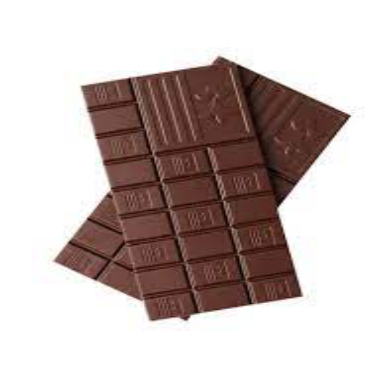

Image 9 distance: 93.14161682128906


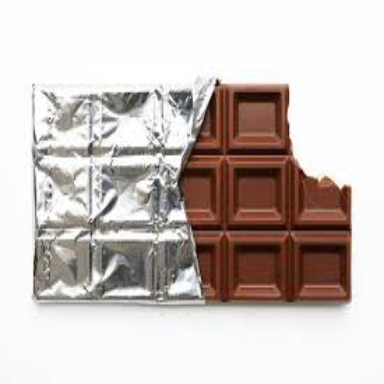

Image 10 distance: 126.01600646972656


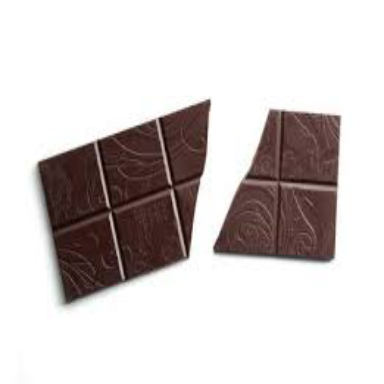

Image 7 distance: 147.508544921875


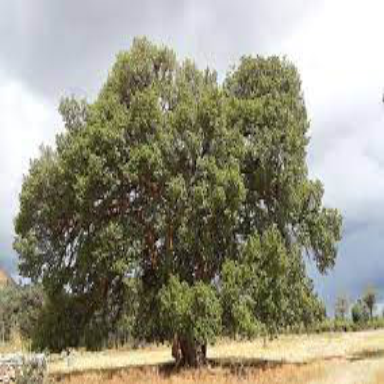

Image 0 distance: 153.10458374023438


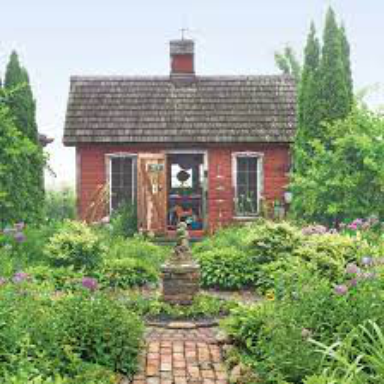

Image 4 distance: 167.6423797607422


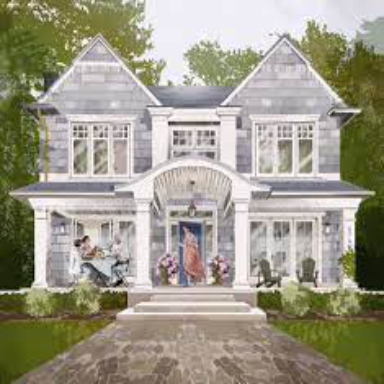

Image 8 distance: 172.04930114746094


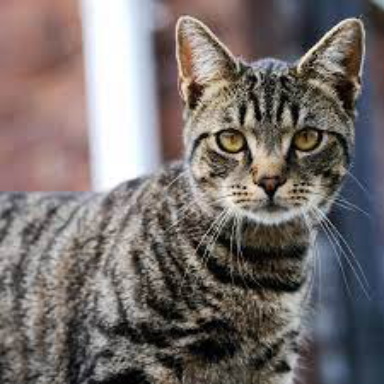

Image 6 distance: 175.22445678710938


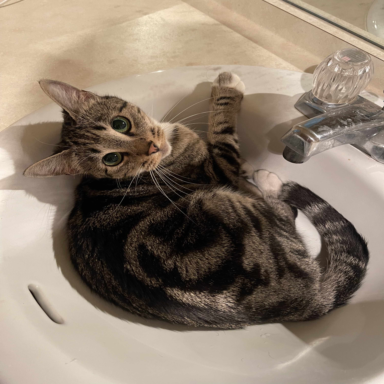

Image 2 distance: 181.42962646484375


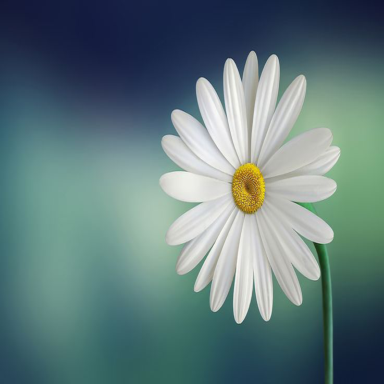

Image 3 distance: 186.8785400390625


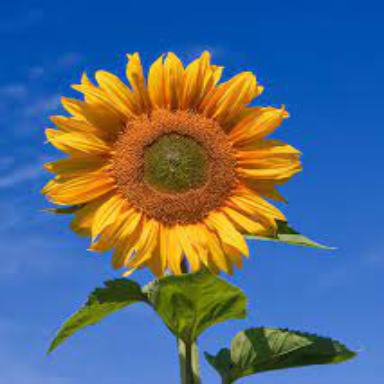

In [ ]:
indices, images, distances = model.search('/content/example_image_corpus/choco.jpg')